# EDA

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == 'notebooks':
    PROJECT_ROOT = PROJECT_ROOT.parent

DATA_PATH = PROJECT_ROOT / 'data' / 'network_dataset_labeled.csv'
if not DATA_PATH.exists():
    raise FileNotFoundError('Set DATA_PATH to your labeled dataset.')

df = pd.read_csv(DATA_PATH)


In [2]:
df.shape


(1001, 21)

In [3]:
df.dtypes


timestamp                      object
bandwidth                       int64
throughput                    float64
congestion                    float64
packet_loss                   float64
latency                       float64
jitter                        float64
Routers                        object
Planned route                  object
Network measure                object
Network target                 object
Video target                   object
Percentage video occupancy      int64
Bitrate video                   int64
Number videos                   int64
anomaly_throughput              int64
anomaly_congestion              int64
anomaly_packet_loss             int64
anomaly_latency                 int64
anomaly_jitter                  int64
anomaly                         int64
dtype: object

In [4]:
df.isna().mean().sort_values(ascending=False).head(10)


Video target     0.2997
bandwidth        0.0000
throughput       0.0000
congestion       0.0000
timestamp        0.0000
packet_loss      0.0000
latency          0.0000
Routers          0.0000
jitter           0.0000
Planned route    0.0000
dtype: float64

In [5]:
df['anomaly'].mean() if 'anomaly' in df.columns else 'missing anomaly column'


np.float64(0.08291708291708291)

## KPI time series with anomalies

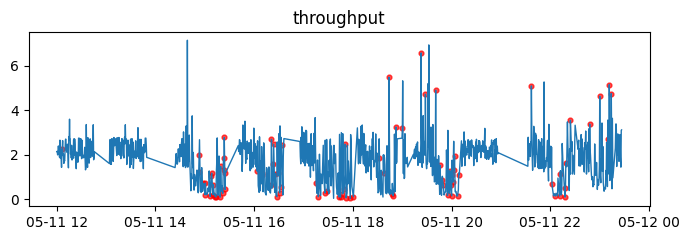

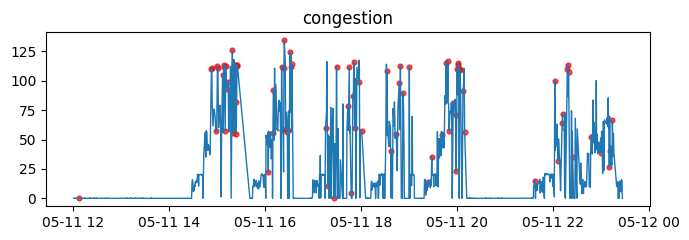

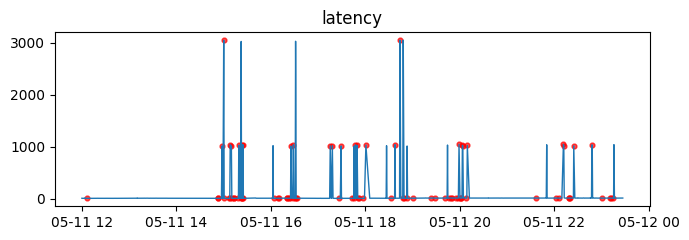

In [6]:
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce', utc=True)
df = df.dropna(subset=['timestamp']).sort_values('timestamp')

kpis = ['throughput','congestion','latency']
for kpi in [k for k in kpis if k in df.columns]:
    plt.figure(figsize=(7, 2.5))
    plt.plot(df['timestamp'], df[kpi], linewidth=1)
    if 'anomaly' in df.columns:
        a = df[df['anomaly'] == 1]
        plt.scatter(a['timestamp'], a[kpi], s=12, color='red', alpha=0.7)
    plt.title(kpi)
    plt.tight_layout()


## KPI distributions: normal vs anomaly

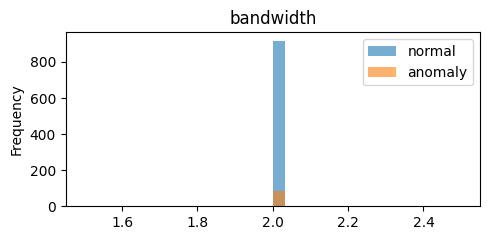

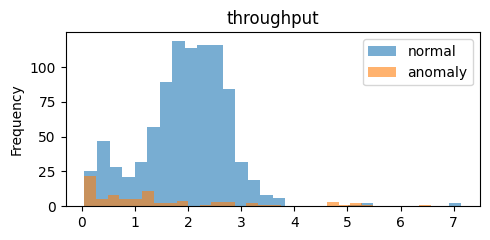

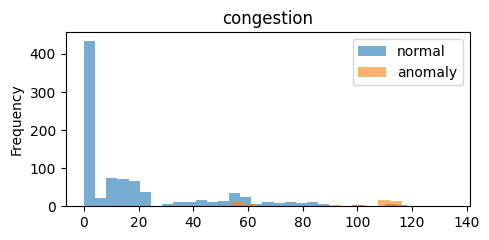

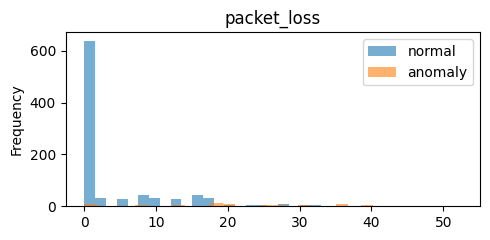

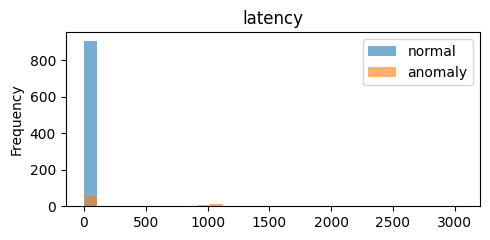

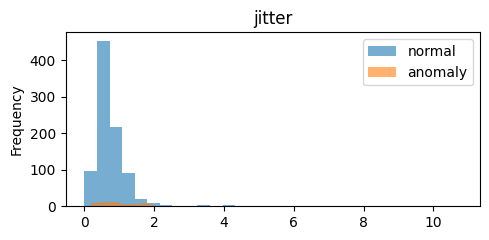

In [7]:
kpi_cols = ['bandwidth','throughput','congestion','packet_loss','latency','jitter']
for kpi in [k for k in kpi_cols if k in df.columns]:
    plt.figure(figsize=(5, 2.5))
    df[df['anomaly'] == 0][kpi].plot(kind='hist', bins=30, alpha=0.6, label='normal')
    df[df['anomaly'] == 1][kpi].plot(kind='hist', bins=30, alpha=0.6, label='anomaly')
    plt.title(kpi)
    plt.legend()
    plt.tight_layout()


## Correlation heatmap (base KPIs)

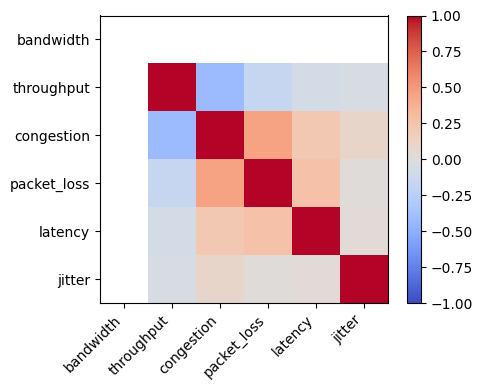

In [8]:
import numpy as np

base_kpis = [k for k in kpi_cols if k in df.columns]
if base_kpis:
    corr = df[base_kpis].corr()
    plt.figure(figsize=(5, 4))
    plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
    plt.xticks(range(len(base_kpis)), base_kpis, rotation=45, ha='right')
    plt.yticks(range(len(base_kpis)), base_kpis)
    plt.colorbar()
    plt.tight_layout()


## Drift check

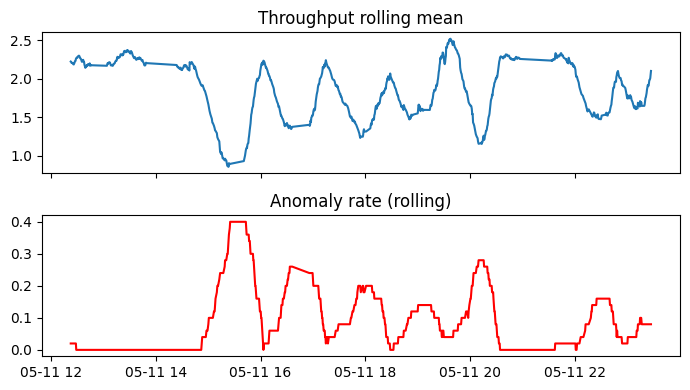

In [9]:
if 'throughput' in df.columns:
    roll = df.set_index('timestamp')['throughput'].rolling(50).mean()
    rate = df.set_index('timestamp')['anomaly'].rolling(50).mean()
    fig, ax = plt.subplots(2, 1, figsize=(7, 4), sharex=True)
    ax[0].plot(roll.index, roll.values)
    ax[0].set_title('Throughput rolling mean')
    ax[1].plot(rate.index, rate.values, color='red')
    ax[1].set_title('Anomaly rate (rolling)')
    plt.tight_layout()
